[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marharyta-aleksandrova/conformal-learning/blob/main/tutorials/Demo_1._Calibration.ipynb)

Installing `nonconformist` library (uncomment the cells below)

In [1]:
# !git clone https://github.com/donlnz/nonconformist

In [2]:
# cd nonconformist

In [3]:
# !python setup.py install

In [3]:
pip install pandas==1.5.3

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Util functions

In [5]:
# Accuracy for a region prediction:
# A region prediction produces an error if the resulting prediction set does not
# contain the true value 
def get_accuracy(prediction, real_class):
    correct = 0
    N = len(prediction)
    for i in range(0, N):
        if prediction[i][real_class[i]]:
            correct += 1
    return correct / N

# calculating metrics: oneC & avgC
def get_oneC_avgC(prediction):
    arr = np.array(prediction)
    oneC = 0
    avgC = 0
    for i in range(0, len(arr)):
        # number of predicted lables
        num_predicted = arr[i].sum()
        avgC += num_predicted
        # is it a singleton?
        if num_predicted == 1:
            oneC += 1
        pass
    oneC /= len(arr)
    avgC /= len(arr)
    return oneC, avgC

# Generating data

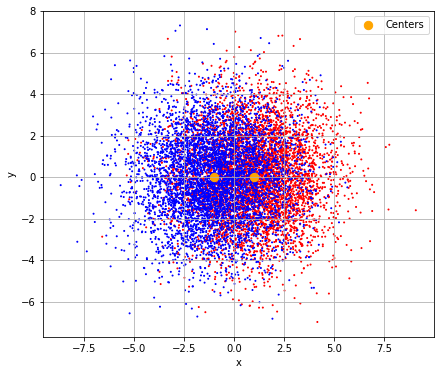

In [6]:
np.random.seed(20)
# centers of 2 classes
centers = [
    [ 1,  0],
    [-1,  0],
]

# colors to plot members of different classes
color_arr = ['r', 'b']

# number of instances per class
n_points = 5000
# these arrays will store information about datapoints
data_x = []
data_y = []
data_class = []
data_color = []

# standard deviation to generate the class instances
sigma = 2.
# data generation
for class_val in range(0, len(centers)):
    x, y = centers[class_val]
    data_class.extend([class_val for j in range(0, n_points)])
    data_color.extend([color_arr[class_val] for j in range(0, n_points)])
    data_x.extend(np.random.normal(x, sigma, size=n_points))
    data_y.extend(np.random.normal(y, sigma, size=n_points))
# putting everything into a dataframe
data_df = pd.DataFrame({
    'x': data_x,
    'y': data_y,
    'class': data_class,
    'color': data_color,
})
# plotting the dataset
data_df.plot(
    kind='scatter',
    x='x',
    y='y',
    c=data_df['color'],
    s=1,
    grid=True,
    figsize=(7,6),
)

# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

# Model training

In [7]:
# fraction of the dataset to be used for testing
test_frac = 0.1

np.random.seed(2)
# performing random permutation of the dataset
idx = np.random.permutation(len(data_df))
# constucting training and test datasets
test_size = int(len(data_df) * 0.1)
train_size = len(data_df) - test_size
idx_train = idx[:train_size]
idx_test = idx[train_size:]

print('Size of training set: {}'.format(len(idx_train)))
print('Size of test set: {}'.format(len(idx_test)))

Size of training set: 9000
Size of test set: 1000


In [8]:
model = SVC(probability=True)

model.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])
prediction = model.predict(data_df[['x', 'y']].values[idx_test, :])
acc = sum(prediction[:] == data_df['class'].values[idx_test][:]) / len(idx_test)
print('Accuracy of prediction: {}%'.format(acc * 100))

Accuracy of prediction: 70.7%


Analysing probabilities

In [9]:
prob_result = model.predict_proba(data_df[['x', 'y']].values[idx_test, :])
prob_result[:5]

array([[0.25436901, 0.74563099],
       [0.70265338, 0.29734662],
       [0.4784148 , 0.5215852 ],
       [0.23368386, 0.76631614],
       [0.25396837, 0.74603163]])

In [10]:
prediction[:5]

array([1, 0, 1, 1, 1], dtype=int64)

# Prediction with accuracy guarantees

We need $95%$ accuracy, `significance = 0.05`

In [11]:
significance = 0.05

## Using probability estimates

In [12]:
prediction_region_naive = prob_result > significance
for i in range(0, 5):
    print('{}: {}'.format(i + 1, prediction_region_naive[i]))

acc = get_accuracy(prediction_region_naive, data_df['class'].values[idx_test])
oneC, avgC = get_oneC_avgC(prediction_region_naive)
print('Accuracy of the region predictor: {}%'.format(acc * 100))
print('Efficiency:\n\t oneC = {}\n\t avgC = {}'.format(oneC, avgC))

1: [ True  True]
2: [ True  True]
3: [ True  True]
4: [ True  True]
5: [ True  True]
Accuracy of the region predictor: 100.0%
Efficiency:
	 oneC = 0.0
	 avgC = 2.0


All labes are included for all instances. This predictor is of low value. Why does it happen?

## Analysis of calibration curves

Check [here](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html) for the source code.

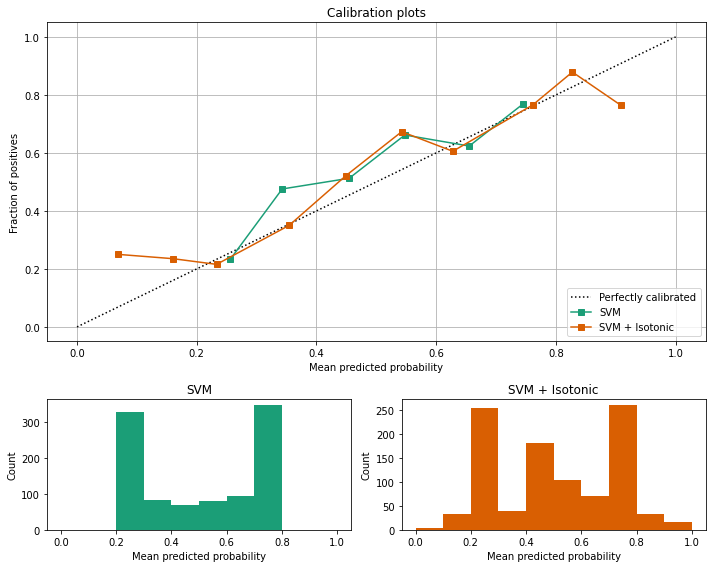

In [13]:
#import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# saving data in arrays
X_train, y_train = data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train]
X_test, y_test = data_df[['x', 'y']].values[idx_test, :], data_df['class'].values[idx_test]

svm = SVC(probability=True)
svm_isotonic = CalibratedClassifierCV(svm, cv=2, method="isotonic")

clf_list = [
    (svm, "SVM"),
    (svm_isotonic, "SVM + Isotonic"), 
    #(lr, "Logistic"),
    #(gnb, "Naive Bayes"),
    #(gnb_isotonic, "Naive Bayes + Isotonic"),
]

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

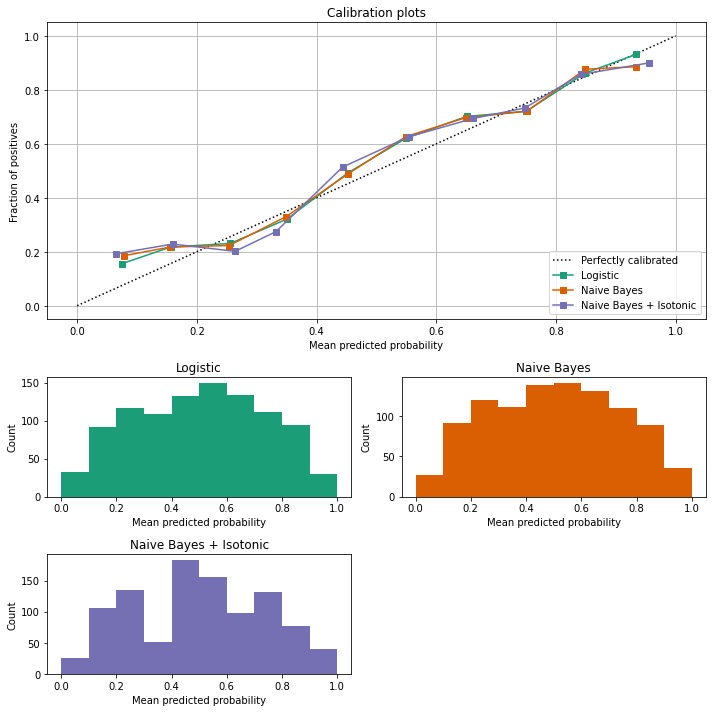

In [14]:
lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")

clf_list = [
    #(svm, "SVM"),
    #(svm_isotonic, "SVM + Isotonic"), 
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Conformal learning

Splitting data into test, train and calibration datasets

In [15]:
# fraction of the dataset to be used for testing
test_frac = 0.1
# fraction of the remaining dataset to be used for calibration
calib_frac = 0.2

np.random.seed(2)
# random permulation
idx = np.random.permutation(len(data_df))
# constucting test, training and calibration datasets
test_size = int(len(data_df) * test_frac) 
calib_size = int(len(data_df) * (1 - test_frac) * calib_frac)
train_size = len(data_df) - test_size - calib_size
idx_train, idx_cal, idx_test = idx[:train_size], idx[train_size:train_size + calib_size], idx[train_size + calib_size:]

print('Test size: {}'.format(test_size))
print('Calibration size: {}'.format(calib_size))
print('Train size: {}'.format(train_size))

Test size: 1000
Calibration size: 1800
Train size: 7200


In [16]:
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc

nc = NcFactory.create_nc(model, err_func=InverseProbabilityErrFunc())	# Create a default nonconformity function
icp = IcpClassifier(nc, smoothing=False)			# Create an inductive conformal classifier

# We comment this line to use the same underlying classifier that was built above.
# Like this, we avoid deviations due to random initializations in the traning phase. 
# Fit the ICP using the proper training set
icp.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])

# Calibrate the ICP using the calibration set
icp.calibrate(data_df[['x', 'y']].values[idx_cal, :], data_df['class'].values[idx_cal])

# Produce predictions for the test set, with confidence 95%
prediction_lib = icp.predict(data_df[['x', 'y']].values[idx_test, :], significance=significance)

In [17]:
prediction_lib

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [False,  True],
       [ True,  True]])

In [18]:
acc = get_accuracy(prediction_lib, data_df['class'].values[idx_test])
oneC, avgC = get_oneC_avgC(prediction_lib)
print('Accuracy of the region predictor: {}%'.format(acc * 100))
print('Efficiency:\n\t oneC = {}\n\t avgC = {}'.format(oneC, avgC))

Accuracy of the region predictor: 94.89999999999999%
Efficiency:
	 oneC = 0.239
	 avgC = 1.761
